In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

!pip3 install -q torch torchvision
!pip3 install -q Pillow

In [2]:
import pandas as pd
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import torchvision.datasets as dset
from PIL import Image
from skimage import io, transform
import torch
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0") # Let's make sure GPU is available!

C:\Users\hissi\.conda\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_folder = "../5_transfer_learning/hotdog-not-hotdog-dataset/train/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

test_folder = "../5_transfer_learning/hotdog-not-hotdog-dataset/test/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 2
Number of files in the test folder 2


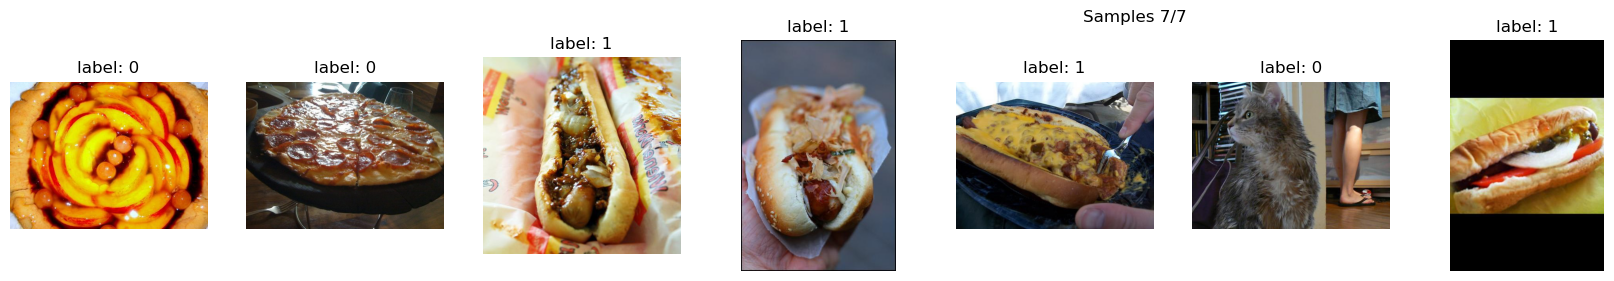

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder

        data_is_hotdog = pd.DataFrame(os.listdir(folder + "hot_dog/"), columns=["img"], index=None)
        data_not_hotdog = pd.DataFrame(os.listdir(folder + "not_hot_dog/"), columns=["img"], index=None)
        data_is_hotdog["target"] = 1
        data_not_hotdog["target"] = 0
        data_is_hotdog["path"] = "hot_dog"
        data_not_hotdog["path"] = "not_hot_dog"
        self.data = pd.concat([data_is_hotdog, data_not_hotdog], axis=0)
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        img_id = index
        if torch.is_tensor(index):
            idx = idx.tolist()

        image_path = os.path.join(self.folder +  self.data["path"][index], self.data["img"][index])
        img = Image.open(image_path)

        y = self.data["target"].iloc[index]

        if self.transform:
            img = self.transform(img)
        
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, reshape=False, count=10):
    plt.figure(figsize=(count * 3, 3))
    display_indices = indices[:count]
    if title:
        plt.suptitle(f"{title} {len(display_indices)}/{len(indices)}")

    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        if reshape:
            x = x.T
        plt.subplot(1, count, i + 1)
        plt.title("label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis("off")

orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

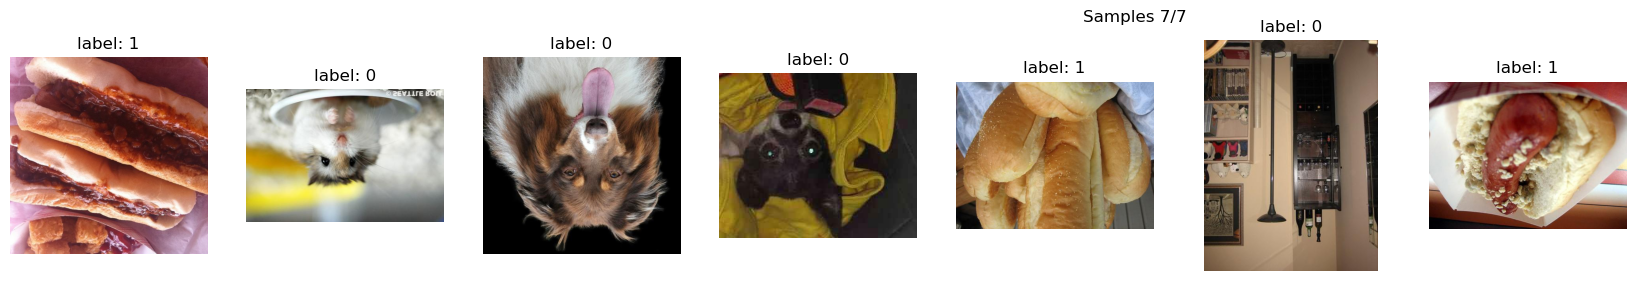

In [5]:
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples")

In [6]:
train_dataset = HotdogOrNotDataset(train_folder,
                                  transform=transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                  ]))
test_dataset = HotdogOrNotDataset(test_folder,
                                  transform=transforms.Compose([
                                      transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                  ]))

C:\Users\hissi\AppData\Local\Temp\ipykernel_17232\3416641843.py:42: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  x = x.T
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

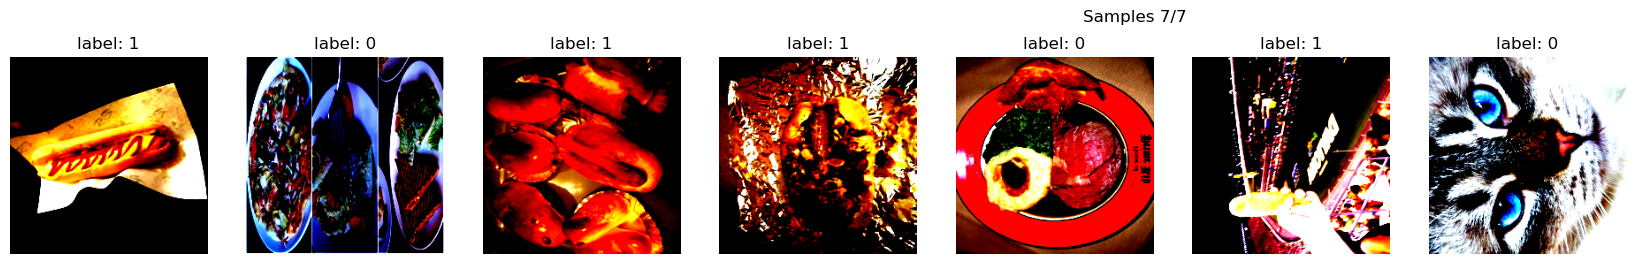

In [7]:
visualize_samples(train_dataset, indices, "Samples", True)

In [8]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs, cuda=True):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        total_samples = 0
        correct_samples = 0
        loss_accum = 0
        
        model.train()
        for i, (x, y, _) in enumerate(train_loader):
            if cuda:
                x_gpu = x.to(device)
                y_gpu = y.to(device)
            else:
                x_gpu = x
                y_gpu = y
            prediction = model(x_gpu)

            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i
        scheduler.step()
        train_accuracy = float(correct_samples / total_samples)
        val_accuracy = compute_accuracy(model, val_loader, cuda)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print(epoch + 1, "Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
    return loss_history, train_history, val_history 

def compute_accuracy(model, loader, cuda=True):
    correct_samples = 0
    total_samples = 0
    model.eval()
    
    for (x, y, _) in loader:
        if cuda:
            x_gpu = x.to(device)
            y_gpu = y.to(device)
        else:
            x_gpu = x
            y_gpu = y

        cat_prediction = model(x_gpu)
        prediction = torch.argmax(cat_prediction, dim=1)

        correct_samples += torch.sum(y_gpu == prediction)
        total_samples += y_gpu.shape[0]

    return correct_samples / total_samples    

In [10]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").read()
    classes = json.loads(classes_json)
    return { int(k): v[-1] for k, v in classes.items()}

model = models.resnet18(weights='IMAGENET1K_V1')

In [11]:
imagenet_dict = load_imagenet_classes()

In [12]:
def visualize_x(loader, counter, model, title="imagenet"):
    for (inputs, targets, _) in loader:
        y = targets
        for i in range(counter):
            img = inputs[i]

            
            if title == "imagenet":
                title = imagenet_dict[int(y[i])]
            elif title == "targets":
                title = targets[i]
            
            # transpose image to fit plt input
            image = img.cpu().numpy()
            image = image.T
            # normalise image
            data_min = np.min(image, axis=(1,2), keepdims=True)
            data_max = np.max(image, axis=(1,2), keepdims=True)
            scaled_data = (image - data_min) / (data_max - data_min)
            # show image
            plt.title(title)
            plt.imshow(scaled_data)
            plt.show() 
        break

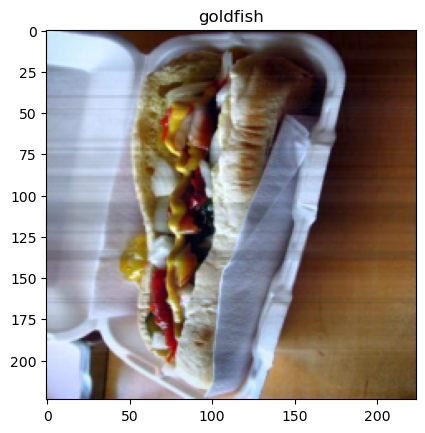

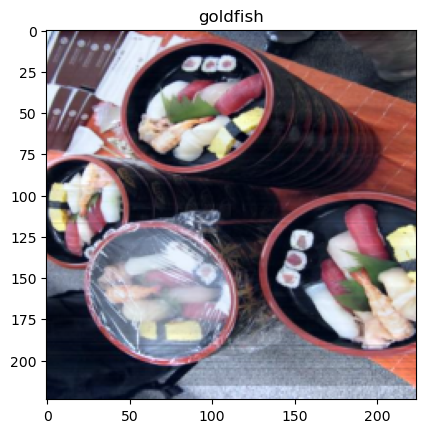

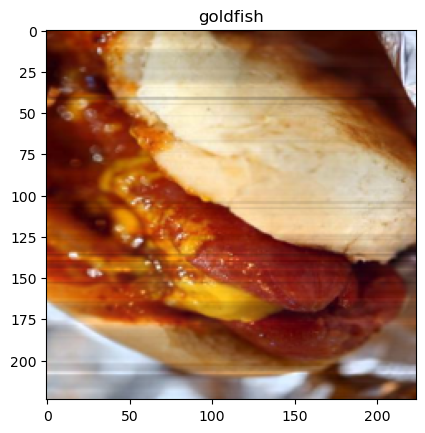

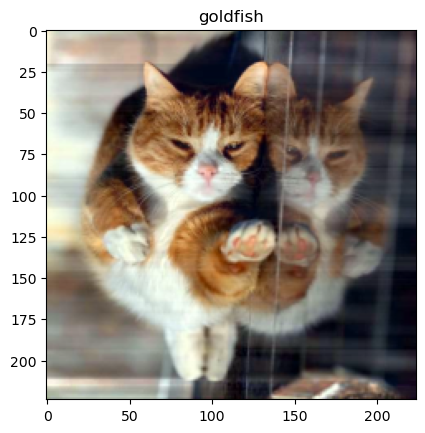

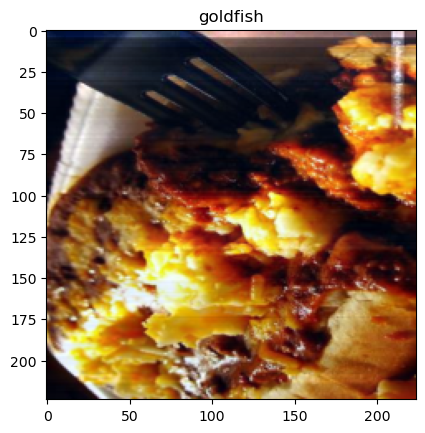

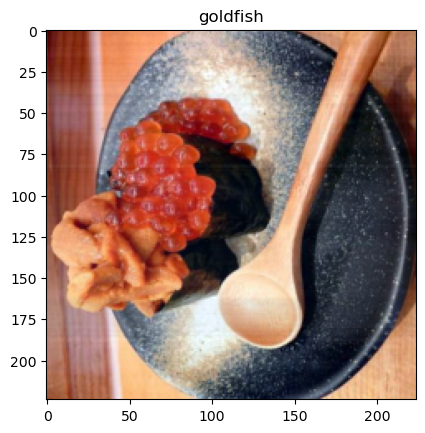

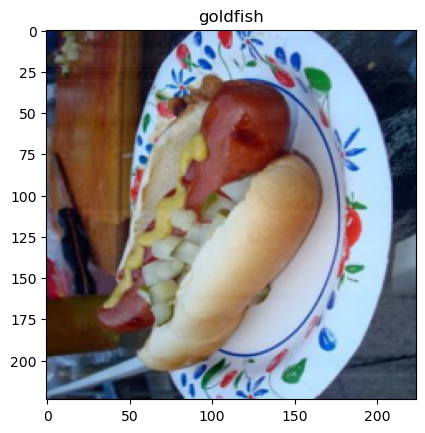

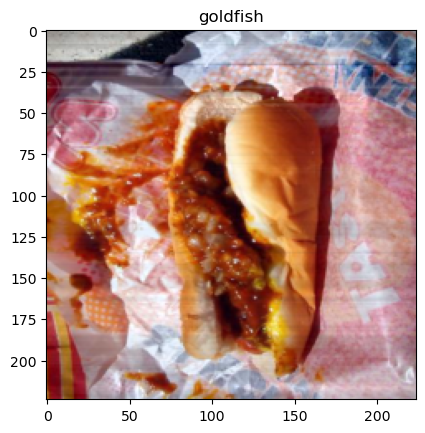

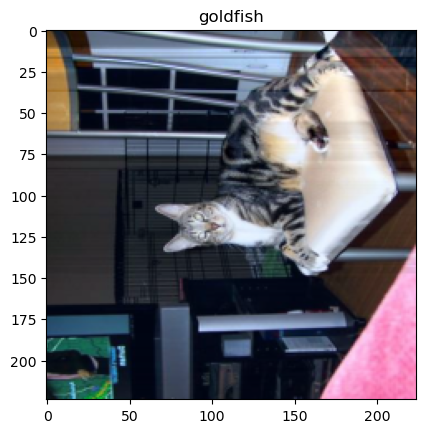

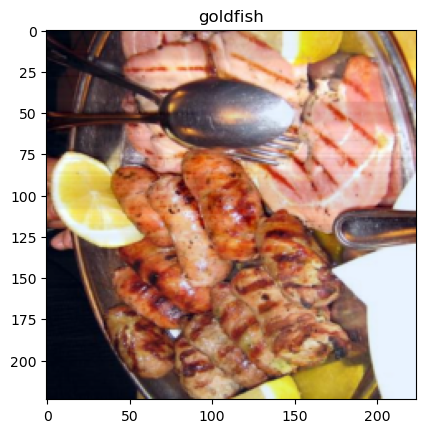

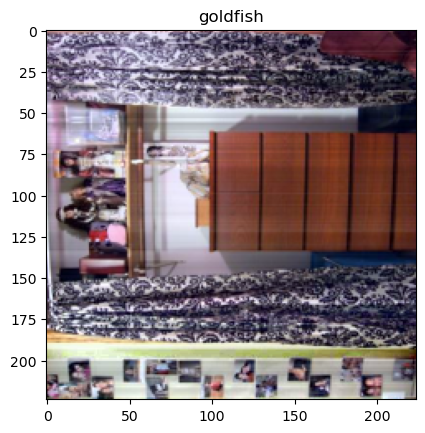

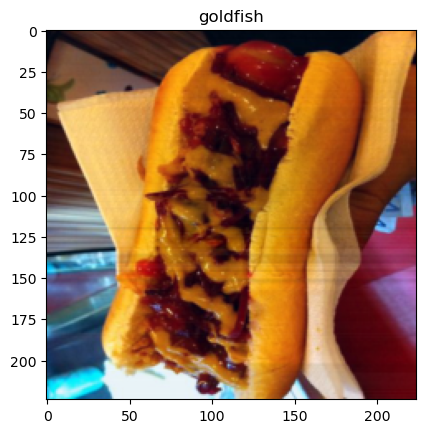

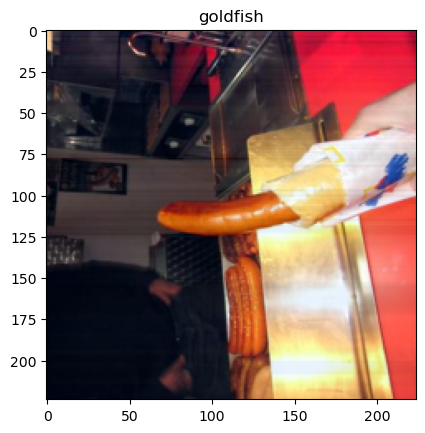

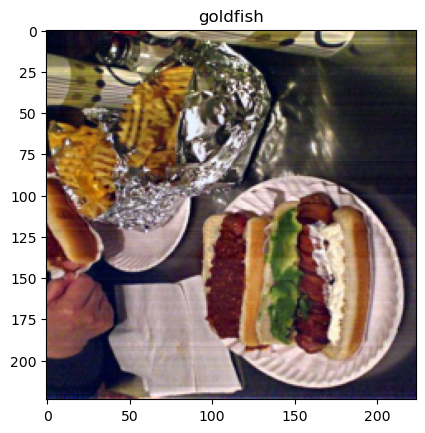

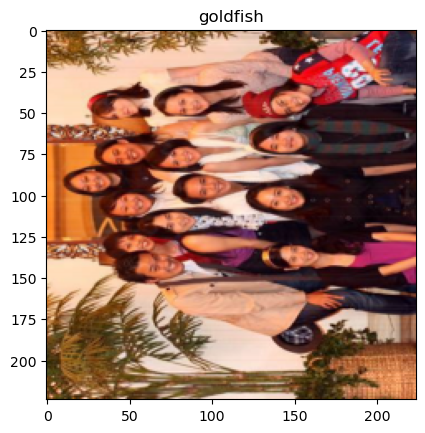

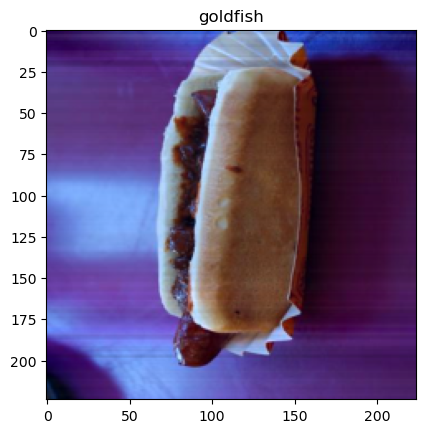

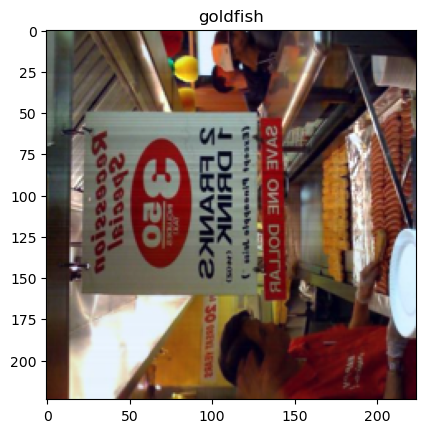

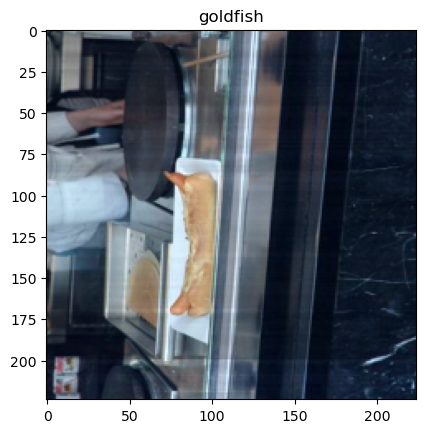

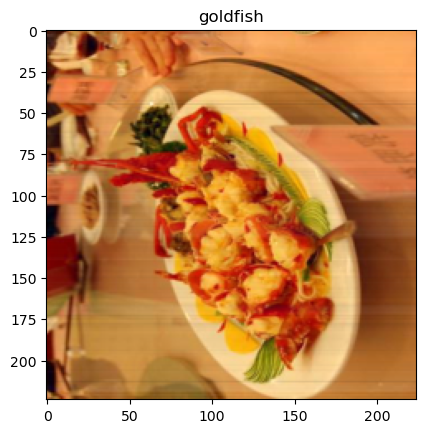

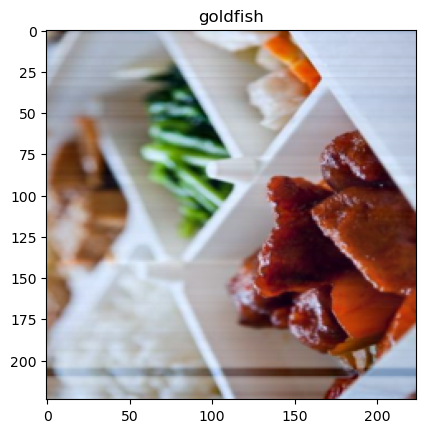

In [13]:
visualize_x(train_loader, 20, model)

### Перенос обучения (transfer learning) - тренировать только последний слой

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
for param in model_ft.parameters(): #морозим градиенты
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.type(torch.cuda.FloatTensor)
model_ft = model_ft.to(device)

# model_ft.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

optimizer_ft = optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [130]:
loss_history, train_history, val_history = train_model(model_ft, train_loader, val_loader, loss, 
                                                       optimizer=optimizer_ft, scheduler=exp_lr_scheduler, 
                                                       num_epochs=2, cuda=True)

1 Average loss: 0.461791, Train accuracy: 0.779005, Val accuracy: 0.870780
2 Average loss: 0.275195, Train accuracy: 0.890957, Val accuracy: 0.901048


### Перенос обучения (transfer learning) - тренировать всю модель

In [14]:
model = models.resnet18(weights="IMAGENET1K_V1")

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.type(torch.cuda.FloatTensor)
# model.type(torch.FloatTensor)
model = model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam([
                {'params': model.layer1.parameters(), 'lr': 1e-4},
                {'params': model.layer2.parameters(), 'lr': 1e-4},
                {'params': model.layer3.parameters(), 'lr': 1e-4},
                {'params': model.layer4.parameters(), 'lr': 1e-4},
                {'params': model.fc.parameters(), 'lr': 1e-3}
            ], lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 
                                                       exp_lr_scheduler, 5, cuda=True)

1 Average loss: 0.249361, Train accuracy: 0.890666, Val accuracy: 0.924331
2 Average loss: 0.042718, Train accuracy: 0.990113, Val accuracy: 0.938300
3 Average loss: 0.006981, Train accuracy: 0.999418, Val accuracy: 0.940629
4 Average loss: 0.003332, Train accuracy: 0.999418, Val accuracy: 0.942957
5 Average loss: 0.001384, Train accuracy: 1.000000, Val accuracy: 0.948778


In [16]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

def evaluate_model(model, dataset, indices, cuda=True):
    model.eval()

    predictions = []
    ground_truth = []

    data_loader = torch.utils.data.DataLoader(dataset, sampler=SubsetSampler(indices))

    for (x, y, _) in data_loader:
        y = torch.tensor(y)

        if cuda:
            x_gpu = x.to(device)
            y_gpu = y.to(device)
        else:
            x_gpu = x
            y_gpu = y 
            
        _, indices = torch.max(model(x_gpu), 1)
        for i in indices:
            predictions.append(i)
            
        true_val = torch.squeeze(y_gpu, dim=0)
        ground_truth.append(true_val)
            
    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

C:\Users\hissi\AppData\Local\Temp\ipykernel_17232\3706140635.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [17]:
len(predictions) == len(gt)

True

In [18]:
predictions = np.array([int(i) for i in predictions])
gt = np.array([int(i) for i in gt])

In [19]:
mask_fp = (predictions == 1) & (gt == 0)
mask_fn = (predictions == 0) & (gt == 1)

In [20]:
indices = np.array(range(len(predictions)))
false_positive_indices = indices[mask_fp]
false_negatives_indices = indices[mask_fn]

[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0]


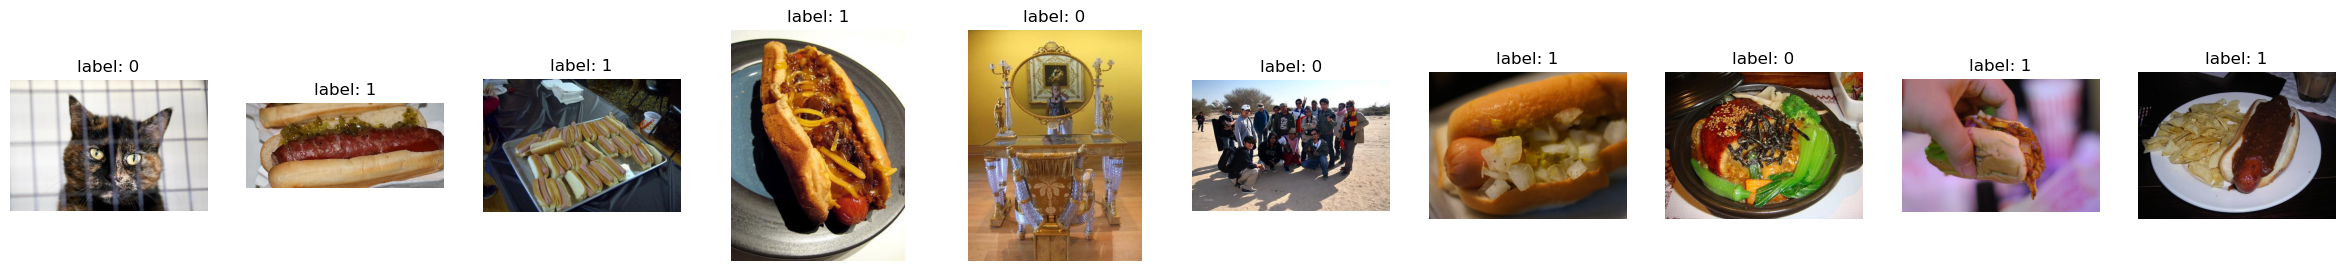

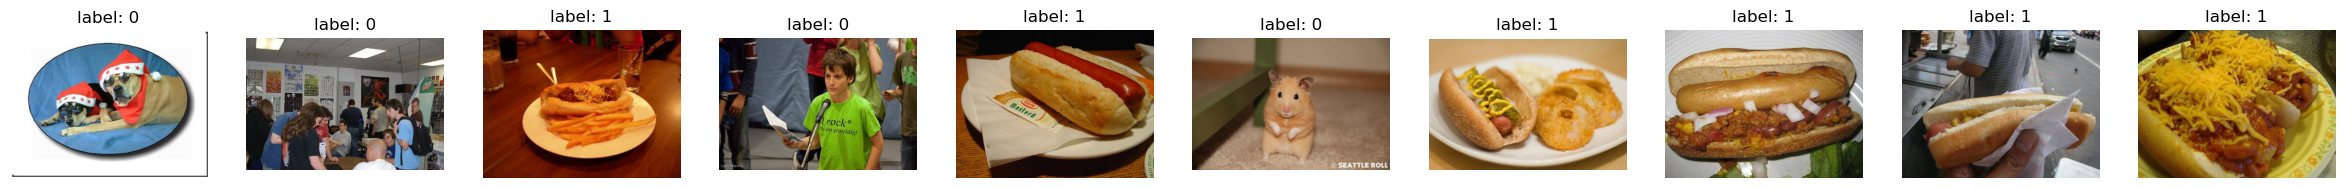

In [22]:
visualize_samples(orig_dataset, false_positive_indices)
print(predictions[false_positive_indices][:10])

visualize_samples(orig_dataset, false_negatives_indices)
print(predictions[false_negatives_indices][:10])

In [24]:
from sklearn.metrics import f1_score, recall_score, precision_score

def binary_classification_metrics(prediction, ground_truth):
    precision = metrics.precision_score(ground_truth, prediction)
    recall = metrics.recall_score(ground_truth, prediction)
    f1 = metrics.f1_score(ground_truth, prediction)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.954, P: 0.944, R: 0.964


In [48]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 
                                                       exp_lr_scheduler, 20, cuda=True)

1 Average loss: 0.007349, Train accuracy: 0.998546, Val accuracy: 0.934808
2 Average loss: 0.026107, Train accuracy: 0.993312, Val accuracy: 0.933644
3 Average loss: 0.009042, Train accuracy: 0.996511, Val accuracy: 0.935972
4 Average loss: 0.005264, Train accuracy: 0.998546, Val accuracy: 0.939465
5 Average loss: 0.004014, Train accuracy: 0.998546, Val accuracy: 0.942957
6 Average loss: 0.006289, Train accuracy: 0.998546, Val accuracy: 0.939465
7 Average loss: 0.001032, Train accuracy: 1.000000, Val accuracy: 0.934808
8 Average loss: 0.001858, Train accuracy: 0.999418, Val accuracy: 0.938300
9 Average loss: 0.000768, Train accuracy: 0.999709, Val accuracy: 0.938300
10 Average loss: 0.001275, Train accuracy: 0.999418, Val accuracy: 0.938300
11 Average loss: 0.000393, Train accuracy: 1.000000, Val accuracy: 0.939465
12 Average loss: 0.000247, Train accuracy: 1.000000, Val accuracy: 0.938300
13 Average loss: 0.000991, Train accuracy: 0.999709, Val accuracy: 0.939465
14 Average loss: 0.00

In [51]:
dataset = HotdogOrNotDataset(train_folder, transform=transforms.Compose([
                                      transforms.RandomVerticalFlip(0.9),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                  ]))

In [52]:
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices) 

C:\Users\hissi\AppData\Local\Temp\ipykernel_17232\3706140635.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [53]:
predictions = np.array([int(i) for i in predictions])
ground_truth = np.array([int(i) for i in ground_truth])

F1: 0.482, P: 0.250, R: 0.329


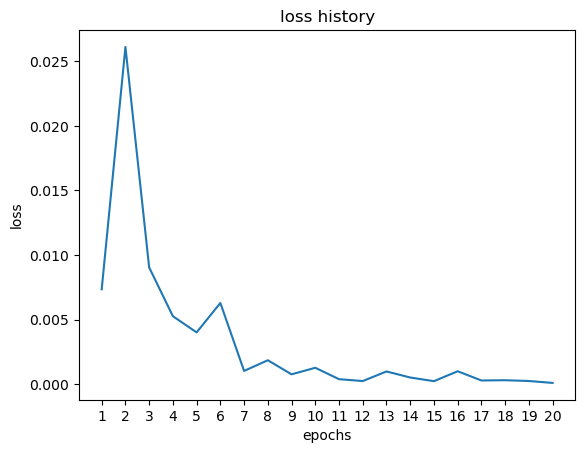

In [58]:
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

plt.plot(list(range(1, 21)), loss_history)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss history")
plt.xticks(list(range(1, 21)));

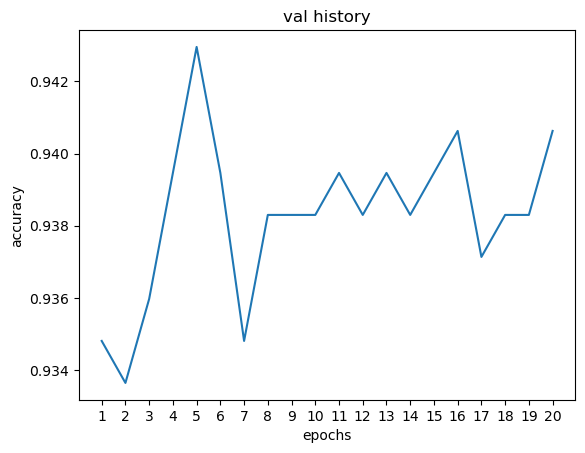

In [57]:
plt.plot(list(range(1, 21)), [float(i) for i in val_history])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("val history")
plt.xticks(list(range(1, 21)));